In [39]:
from qutip import *
from scipy import linalg
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy import integrate

from numpy import savetxt
from numpy import loadtxt

In [21]:
## XY drive (Omega_x, Omega_y);  Z & amp error (X,Y)
def gate_fidelity_qubit_XY_Z_amp1(delta_z,epsilon,Px,Py,tlist,U_ideal):  # P :: array  (pulse in array form)
    
    delta_z = delta_z * 2*np.pi
    
    U0 = tensor(qeye(2))
    pul_x = interp1d(tlist, Px, kind='cubic') # pul :: interpolate function
    pul_y = interp1d(tlist, Py, kind='cubic')
    
    size_matrix = np.shape(U0)
    size_array = np.size(U0)
    
    def deriv(t,U):
        """
        Right hand side of the differential equations
          dU/dt = - i*H(t)*U
        """
        Udot = -1j * np.dot(H.full(), np.reshape(U, size_matrix))
        return np.reshape(Udot, size_array)
    
    def ode_qubit(delta_z,epsilon,tlist,pul_x,pul_y):
        U_list = []
        U_list.append(U0)

        U_step = np.reshape(U0, size_array)
        for k in range(len(tlist)-1):
            global H
            H =  0.5*delta_z*sigmaz() + \
            + (1+epsilon)*0.5*pul_x((tlist[k]+tlist[k+1])/2)*sigmax() \
            + (1+epsilon)*0.5*pul_y((tlist[k]+tlist[k+1])/2)*sigmay()
            
            sol = integrate.solve_ivp(deriv,(tlist[k],tlist[k+1]),(U_step), method='RK45')
            U_step = np.transpose(sol.y)[-1]
            U_list.append(np.reshape(U_step, size_matrix))

        Uf = Qobj(U_list[-1])
        return Uf
    
    U_f = ode_qubit(delta_z,epsilon,tlist,pul_x,pul_y)
    
    Uf = Qobj(Qobj(U_f).data.toarray().reshape((2,2)),dims=[[2],[2]])
    M = U_ideal.dag()*Uf
    F = 1/6 * (np.trace(M*M.dag()) + abs(np.trace(M))**2 )

    return np.real(F)

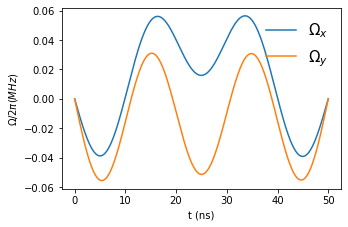

In [43]:
Px = loadtxt(r"C:\Users\Quantum\Desktop\DCG_new\pulse\amp\%s.csv" %'P_pi_z_amp_Nc=2_Omega_x', delimiter=',')
Py = loadtxt(r"C:\Users\Quantum\Desktop\DCG_new\pulse\amp\%s.csv" %'P_pi_z_amp_Nc=2_Omega_y', delimiter=',')

tlist = np.linspace(0,50,501)

fig, ax = plt.subplots(figsize=(5,5*2/3))
ax.plot(tlist,Px/(2*np.pi),label="$\Omega_x$")
ax.plot(tlist,Py/(2*np.pi),label="$\Omega_y$")
ax.set_xlabel('t (ns)')
ax.set_ylabel('$\Omega/2\pi (MHz)$')
ax.legend(loc='best',prop={'size':15},frameon=False)

0.5000000000000002

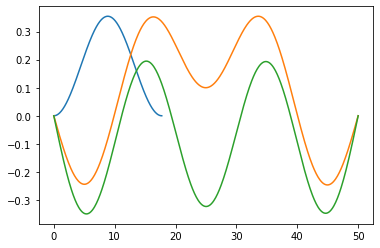

In [44]:
p_max = max([max(Px),max(Py)])
angle = np.pi
T_cos = angle/(0.5*p_max)
tlist_cos = np.linspace(0,T_cos,501)
def f_cos(t,T_cos,p_max):
    return 0.5*p_max*(1+np.cos((t-T_cos/2)*(2*np.pi/T_cos)))

P_cos = f_cos(tlist_cos,T_cos,p_max)
plt.plot(tlist_cos,P_cos)
plt.plot(tlist,Px)
plt.plot(tlist,Py)

sum(P_cos*(tlist_cos[1]-tlist_cos[0]))/(2*np.pi)

In [45]:
M = 51
U_ideal = (-1j * 1/2 * angle *sigmax()).expm()
delta_z1 = np.linspace(-0.15*p_max/(2*np.pi),0.15*p_max/(2*np.pi),M)
epsilon_1 = np.linspace(-0.15,0.15,M)

F_list_z = np.zeros((len(delta_z1)))
F_list_z_cos = np.zeros((len(delta_z1)))

F_list_amp = np.zeros((len(epsilon_1)))
F_list_amp_cos = np.zeros((len(epsilon_1)))


for i in range(len(delta_z1)):
    delta = delta_z1[i]
    F_list_z[i] = gate_fidelity_qubit_XY_Z_amp1(delta,0,Px,Py,tlist,U_ideal)
    F_list_z_cos[i] = gate_fidelity_qubit_XY_Z_amp1(delta,0,P_cos,np.zeros(501),tlist_cos,U_ideal)
    
    epsilon = epsilon_1[i]
    F_list_amp[i] = gate_fidelity_qubit_XY_Z_amp1(0,epsilon,Px,Py,tlist,U_ideal)
    F_list_amp_cos[i] = gate_fidelity_qubit_XY_Z_amp1(0,epsilon,P_cos,np.zeros(501),tlist_cos,U_ideal)

Text(0, 0.5, '$1-F$')

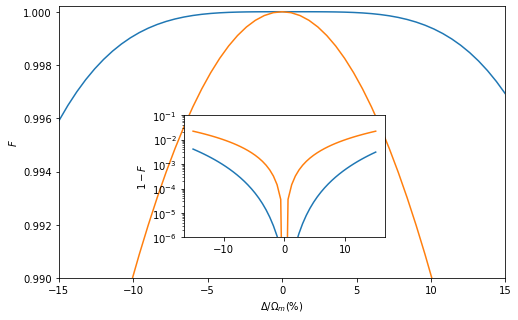

In [46]:
x = np.linspace(-15,15,M)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot( x, F_list_z, 'C0')
ax.plot( x, F_list_z_cos, 'C1')

ax.set_ylim(0.99, 1.0002)
ax.set_xlim(-15, 15)
ax.set_xlabel('$\Delta/\Omega_m (\%)$')
ax.set_ylabel('$F$')
axin1 = ax.inset_axes([0.28, 0.15, 0.45, 0.45])
axin1.plot( x, [1 - i for i in F_list_z], 'C0')
axin1.plot( x, [1 - i for i in F_list_z_cos], 'C1')


axin1.set_ylim(10**(-6), 10**(-1))
axin1.set_yscale('log')
axin1.set_ylabel('$1-F$')

Text(0, 0.5, 'Infidelity')

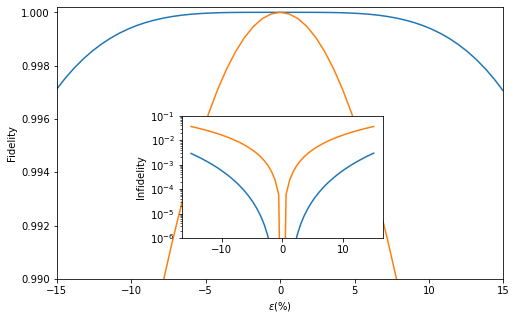

In [47]:
x = np.linspace(-15,15,M)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot( x, F_list_amp, 'C0')
ax.plot( x, F_list_amp_cos, 'C1')

ax.set_ylim(0.99, 1.0002)
ax.set_xlim(-15, 15)
ax.set_xlabel('$\epsilon (\%)$')
ax.set_ylabel('Fidelity')
axin1 = ax.inset_axes([0.28, 0.15, 0.45, 0.45])
axin1.plot( x, [1 - i for i in F_list_amp], 'C0')
axin1.plot( x, [1 - i for i in F_list_amp_cos], 'C1')

#axin1.set_xlim(-10, 10)
axin1.set_ylim(10**(-6), 10**(-1))
#axin1.axhline(y=10**(-4), xmin=-10, xmax=10, linestyle='--', c='dimgray',zorder=0, linewidth=1.2 )
axin1.set_yscale('log')
# axin1.set_xlabel('$\epsilon (\%)$')
axin1.set_ylabel('Infidelity')